In [20]:
import shapely
import shapely.wkt
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import numpy as np
import os
import seaborn as sns
warnings.filterwarnings("ignore")

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from modules.transform import calculate_distance_matrix, od_matrix_to_links
from modules.transform import load_graph_geometry, get_accessibility_isochrone
from modules.transform import dfs2nx
from modules.ilp_solver import ilp_distribute
from modules.dcgm import dcgm_distribute
from modules.dcgm_custom import custom_dcgm_distribute

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [2]:
# territorial units
municipalities = gpd.read_file("data/mo.geojson")
blocks = gpd.read_file("data/blocks.geojson")

# houses and facilities
houses = gpd.read_file("data/houses.geojson").set_index("internal_id")
facilities = gpd.read_file("data/facilities_kindergartens.geojson").set_index("internal_id")

houses = houses.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)
facilities = facilities.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)

# road network
network = nx.read_graphml("data/road_network.graphml", node_type=int)
road_network = load_graph_geometry(network, node=True)

In [3]:
houses.head()

,demand,x,y,geometry,municipality_id
internal_id,,,,,
112224,31.0,355274.215073,6.646370e+06,POINT (355274.21507 6646370.02189),40
112227,11.0,355919.101248,6.646158e+06,POINT (355919.10125 6646157.60580),40
112238,11.0,355850.453714,6.645833e+06,POINT (355850.45371 6645832.60356),40
112245,27.0,356236.545409,6.646253e+06,POINT (356236.54541 6646252.62088),40
112247,8.0,355095.126696,6.645972e+06,POINT (355095.12670 6645971.67007),40


In [4]:
facilities.head()

,capacity,geometry,municipality_id
internal_id,,,
146052,180,POINT (355926.257 6646348.659),40
147014,260,POINT (355210.553 6646144.290),40
146628,384,POINT (355342.209 6646963.423),40
147013,384,POINT (355295.284 6646083.115),40
146576,280,POINT (356073.299 6645598.029),40


#### **Disatnce Matrix (DM)**

In [5]:
# calculate distance matrix based on OSM road network
DM = calculate_distance_matrix(network, houses, facilities)

  0%|          | 0/21464 [00:00<?, ?it/s]

#### **Integer Linear Programming (ILP) and Doubly-Constrained Gravity Model (DCGM)**

In [6]:
# model population-facilties interactions with ILP

kindergarten_ca = 600 # kindergarten catchment area
DM = calculate_distance_matrix(network, houses, facilities)
OD_ILP = ilp_distribute(houses, facilities, DM, selection_range=kindergarten_ca)

  0%|          | 0/21464 [00:00<?, ?it/s]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
# model population-facilties interactions with classic DCGM
# ! DOESN'T CONVERGE

OD_DCGM = dcgm_distribute(houses, facilities, DM)

ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 227.0 Residual capacity: 17121.0
ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 223.0 Residual capacity: 17117.0
ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 223.0 Residual capacity: 17117.0
The matrix balancing doesn't converge.


In [7]:
#  model population-facilties interactions with custom DCGM

OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, kindergarten_ca, p=0)

100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [8]:
# merge results into dfs

dist = kindergarten_ca

houses["supported_demand_ilp"] = OD_ILP[DM <= dist][houses.index].fillna(0).sum()
houses["supported_demand_dcgm"] = OD_СDCGM[DM <= dist][houses.index].fillna(0).sum()

houses["provision_ilp"] = houses["supported_demand_ilp"] / houses["demand"]
houses["provision_dcgm"] = houses["supported_demand_dcgm"] / houses["demand"]

houses["left_demand_ilp"] = houses["demand"] - houses["supported_demand_ilp"]
houses["left_demand_dcgm"] = houses["demand"] - houses["supported_demand_dcgm"]

facilities["left_capacity_ilp"] = facilities["capacity"] - OD_ILP[DM <= dist].fillna(0).sum(1)
facilities["left_capacity_dcgm"] = facilities["capacity"] - OD_СDCGM[DM <= dist].fillna(0).sum(1)

# aggregate assessments into municipalities
houses_aggr = houses.groupby(["municipality_id"]).sum()
municipalities = municipalities.join((houses_aggr["supported_demand_ilp"] / houses_aggr["demand"]).rename("provision_ilp"), on="id")
municipalities = municipalities.join((houses_aggr["supported_demand_dcgm"] / houses_aggr["demand"]).rename("provision_dcgm"), on="id")

edges_ilp = od_matrix_to_links(OD_ILP, DM, houses, facilities)
edges_dcgm = od_matrix_to_links(OD_СDCGM, DM, houses, facilities)

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

In [6]:
houses.to_file("output/houses.geojson")
facilities.to_file("output/facilities.geojson")
municipalities.to_file("output/mo_aggr.geojson")

edges_ilp.to_file("output/edges_ilp.geojson")
edges_dcgm.to_file("output/edges_dcgm.geojson")

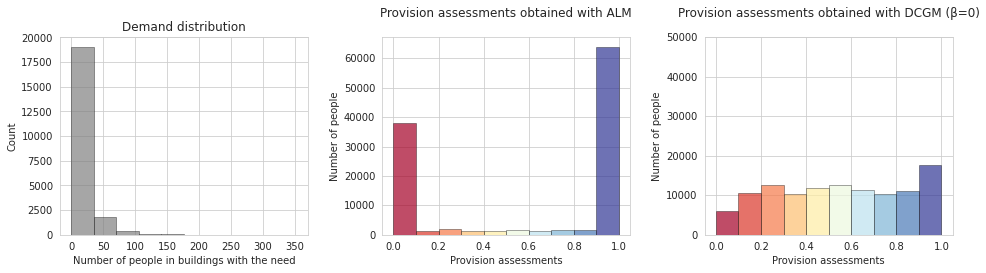

In [9]:
# plot provision assessments distribution

def set_color_map(bins, patches, color_palette):
    cm = plt.cm.get_cmap(color_palette)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

dist = kindergarten_ca
houses_loc = houses
facilities_loc = facilities

p_ilp = houses_loc.loc[houses_loc.index.repeat(houses_loc.demand)]["provision_ilp"]
p_dcgm = houses_loc.loc[houses_loc.index.repeat(houses_loc.demand)]["provision_dcgm"]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

n, bins, patches = ax1.hist(houses_loc["demand"], 10, alpha = 0.7, color='grey', edgecolor='black', linewidth=0.5)
ax1.set_xlabel("Number of people in buildings with the need")
ax1.set_ylabel("Count")
ax1.set_title("Demand distribution")

ax2_n, bins, patches = ax2.hist(p_ilp[p_ilp != p_dcgm], 10, alpha = 0.7, edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax2.set_xlabel("Provision assessments")
ax2.set_ylabel("Number of people")
ax2.set_title("Provision assessments obtained with ALM", pad=20)

ax3_n, bins, patches = ax3.hist(p_dcgm[p_ilp != p_dcgm], 10, alpha = 0.7, edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax3.set_yticks(list(range(0, 60000, 10000)))
ax3.set_xlabel("Provision assessments")
ax3.set_ylabel("Number of people")
ax3.set_title("Provision assessments obtained with DCGM (β=0)", pad=20)

plt.savefig('provision_diagrams.png', dpi=300)

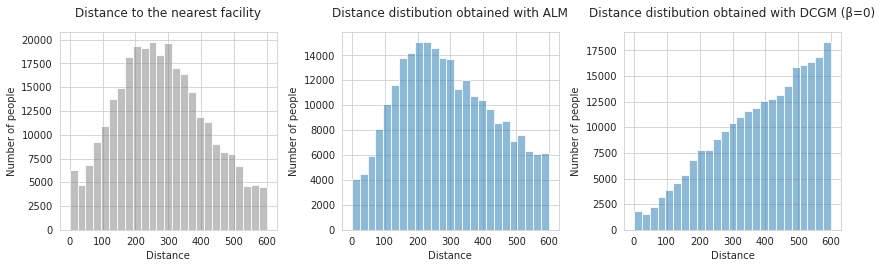

In [10]:
dist = kindergarten_ca
houses_loc = houses 

fig = plt.figure(figsize=(14, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

distances_ilp = DM[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
distances_ilp = distances_ilp[~np.isnan(distances_ilp)]
flows_ilp = OD_ILP[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
flows_ilp = flows_ilp[~np.isnan(flows_ilp)]

distances = DM.min().loc[houses_loc.index]
demand = houses["demand"].loc[houses_loc.index]

f_dist_nearest = pd.DataFrame({"distance": list(distances[distances <= dist]), "demand": demand[distances <= dist]})
f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=dist], "flows":flows_dcgm[distances_dcgm<=dist]})
f_dist_ilp = pd.DataFrame({"distance": distances_ilp[distances_ilp<=dist], "flows":flows_ilp[distances_ilp<=dist]})

sns.histplot(data=f_dist_nearest, x="distance", bins=25, alpha = 0.5, ax=ax1, kde=False, color="gray", weights='demand')
ax1.set_title("Distance to the nearest facility", pad=15)
ax1.set_xlabel("Distance")
ax1.set_ylabel("Number of people")

sns.histplot(data=f_dist_ilp, x="distance", bins=25, alpha = 0.5, ax=ax2, kde=False, weights='flows')
ax2.set_title("Distance distibution obtained with ALM", pad=15)
ax2.set_xlabel("Distance")
ax2.set_ylabel("Number of people")

sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=ax3, kde=False, weights='flows')
ax3.set_title("Distance distibution obtained with DCGM (β=0)", pad=15)
ax3.set_xlabel("Distance")
ax3.set_ylabel("Number of people")


plt.savefig('distance_diagrams.png', dpi=300)

100%|██████████| 9/9 [00:55<00:00,  6.18s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.39s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:51<00:00,  5.70s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:49<00:00,  5.54s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:51<00:00,  5.67s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:52<00:00,  5.83s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


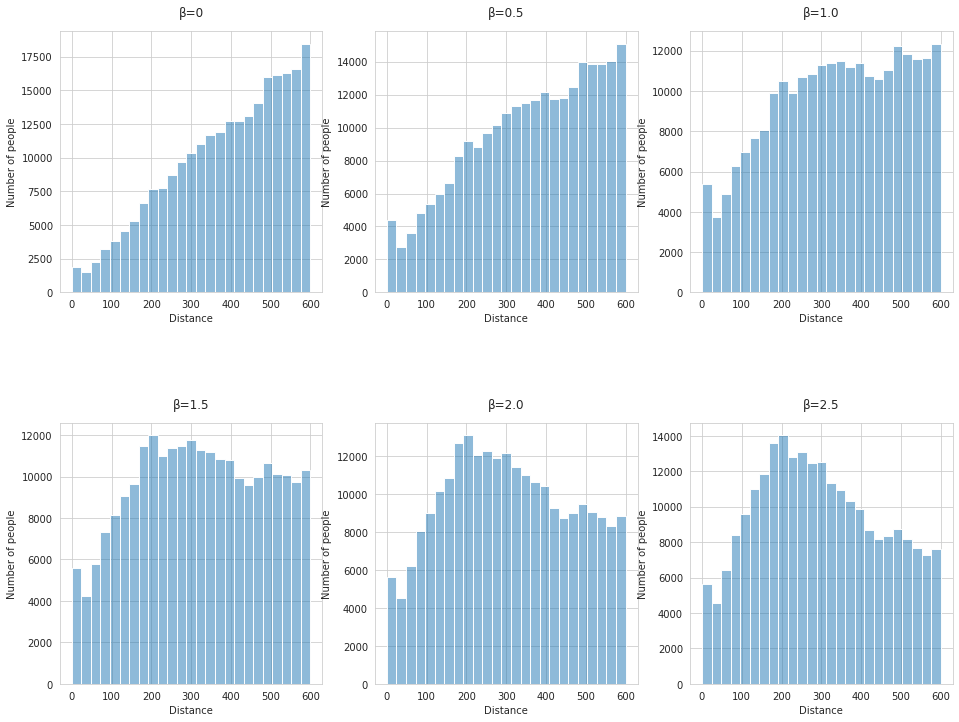

In [106]:
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

p = 0

houses_loc = houses
for i in range(1, 7):
    OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=p)

    distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
    flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

    f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=dist], "flows":flows_dcgm[distances_dcgm<=dist]})

    sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=locals()["ax" + str(i)], kde=False, weights='flows')
    locals()["ax" + str(i)].set_title(f"β={str(p)}", pad=15)
    locals()["ax" + str(i)].set_xlabel("Distance")
    locals()["ax" + str(i)].set_ylabel("Number of people")

    p += 0.5

plt.savefig('distance_distribution.png', dpi=300)

In [11]:
# Population-to-provider ratio in joint 
diff = houses["left_demand_ilp"] - houses["left_demand_dcgm"]

dm = (DM <= dist)
demand_around = dm.progress_apply(lambda x: houses['demand'][dm.loc[facilities["capacity"][x].index].any()].sum())
sum_capacity = dm.progress_apply(lambda x: facilities["capacity"][x].sum())
ratio = sum_capacity / demand_around

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

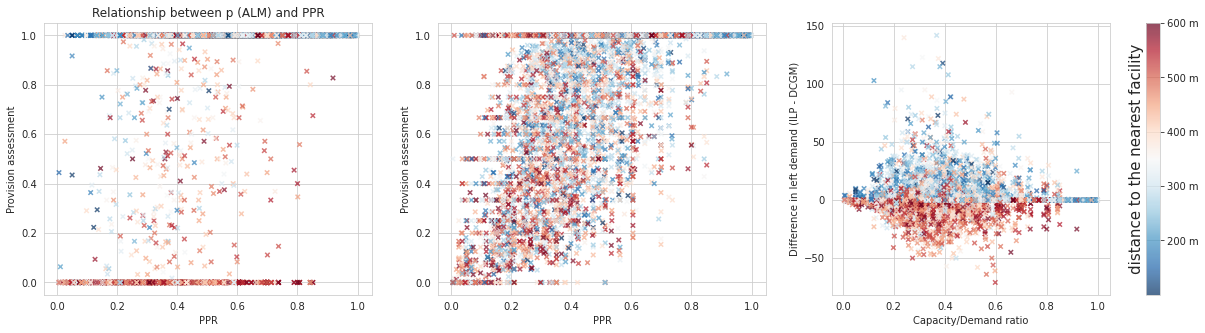

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
color_palette = plt.cm.get_cmap("RdBu_r")
distances = list(DM.min()[ratio < 1])
color_pointer = [i / max(distances) for i in distances]

ax1.set_xlabel("PPR")
ax1.set_ylabel("Provision assessment")
a = ax1.scatter(ratio[ratio < 1], houses["provision_ilp"][ratio < 1], c=color_pointer, cmap=color_palette, s=20, marker="x", alpha=0.7)
ax1.set_title("Relationship between p (ALM) and PPR")
ax1.tick_params(labelsize = 10)

ax2.set_xlabel("PPR")
ax2.set_ylabel("Provision assessment")
b = ax2.scatter(ratio[ratio < 1], houses["provision_dcgm"][ratio < 1], c=color_pointer, cmap=color_palette, s=20, marker="x", alpha=0.7)
ax2.tick_params(labelsize = 10)

ax3.set_xlabel("Capacity/Demand ratio")
ax3.set_ylabel("Difference in left demand (ILP - DCGM)")
c = ax3.scatter(ratio[ratio < 1], -diff[ratio < 1], c=color_pointer, cmap=color_palette, s=20, marker="x", alpha=0.7)
ax3.tick_params(labelsize = 10)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.5)

cbar = fig.colorbar(a, cax=cax, orientation='vertical')
cbar.set_label("distance to the nearest facility", labelpad=-70, size=15)
cbar.set_ticklabels([str(d) + " m" for d in range(100, int(max(distances)) + 1, 100)])
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)

plt.savefig('provision_assessment_relation.png', dpi=300)

In [13]:
# transform dfs to graphs networkx

ilp_graph = dfs2nx(DM, OD_ILP, houses, facilities, 600)
ilp_graph_components = [ilp_graph.subgraph(c).copy() for c in nx.connected_components(ilp_graph.to_undirected())]
dcgm_graph = dfs2nx(DM, OD_СDCGM, houses, facilities, 600)
dcgm_graph_components = [dcgm_graph.subgraph(c).copy() for c in nx.connected_components(dcgm_graph.to_undirected())]

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

In [ ]:
# to vizualize graph as geoobjects (nodes, links)

nodes_ilp = []
edges_ilp = []
for i, c in tqdm(enumerate(ilp_graph_components), total=len(ilp_graph_components)):
    gdf_nodes = gpd.GeoDataFrame.from_dict(dict(c.nodes(data=True)), orient='index')
    gdf_nodes['geometry'] = gdf_nodes['geometry'].apply(wkt.loads)
    gdf_nodes["component"] = i
    nodes_ilp.append(gdf_nodes)

    gdf_edges = nx.to_pandas_edgelist(c)
    gdf_edges["component"] = i
    gdf_edges["geometry"] = gdf_edges.apply(
        lambda x: shapely.geometry.LineString((gdf_nodes.geometry[x.source], gdf_nodes.geometry[x.target])),
        axis=1)
    edges_ilp.append(gdf_edges)

nodes_ilp = pd.concat(nodes_ilp)
edges_ilp = pd.concat(edges_ilp)

gpd.GeoDataFrame(edges_ilp).to_file("output/graph_edges_components.geojson", driver="GeoJSON")
gpd.GeoDataFrame(nodes_ilp).to_file("output/graph_nodes_components.geojson", driver="GeoJSON")

In [ ]:
# calculate 600 m walk isohrones 

facilities_loc = nodes_ilp[nodes_ilp["type"] == 0]
components = list(facilities_loc["component"].unique())
zones = []

limit = 600
edge_weight = "length_meter"
crs = 32636
for c in tqdm(components, total=len(components)):
    isochrones = []
    facilities_zone = facilities_loc[facilities_loc["component"] == c]

    for index, row in facilities_zone.iterrows():
        point = (row["geometry"].xy[0][0], row["geometry"].xy[1][0])
        isochrone = get_accessibility_isochrone(road_network, "walk", point[0], point[1], limit, edge_weight, crs)
        isochrones.append(isochrone)

    df_isochrones = pd.concat(isochrones)
    united_isochrones = gpd.GeoDataFrame({"geometry": [df_isochrones["geometry"].to_crs(32636).unary_union], "component": [c]})
    zones.append(united_isochrones)
    
isochrone_zones = pd.concat(zones).reset_index(drop=True)

In [22]:
isochrones = gpd.read_file("/var/essdata/IDU/other/mm_22/facility_provision/select.geojson")

##### **Neural net**

In [1]:
import numpy as np
import torch
import random
import json
import os

from modules import fnn
from modules import gnn
from modules import linear

from tensorboardX import SummaryWriter
from datetime import datetime
from torch_geometric.loader.dataloader import DataLoader
from tqdm.notebook import tqdm

from modules.dataset import ProvisionSparseDataset_v2
from modules.metrics import cross_validation
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# torch.manual_seed(42)
# random.seed(42)
# np.random.seed(42)

In [2]:
dataset_ilp = ProvisionSparseDataset_v2("data/pyg_data/ilp")
dataset_dcgm = ProvisionSparseDataset_v2("data/pyg_data/dcgm/0")

In [3]:
gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

fnn_param_v0 = {"input_dim": 3, "hidden_dim": 32, "output_dim": 1, "num_layers": 4, "dropout": 0.20}
fnn_param_v1 = {"input_dim": 128 * 2 + 5, "hidden_dim": 64, "output_dim": 1, "num_layers": 4, "dropout": 0.20}

fnn_param_v2_1 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 1, "dropout": 0.20}
fnn_param_v2_2 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 2, "dropout": 0.20}

models = {
    'log_regression': {'embeddings': None, 'prediction': [LinearRegression(), None]},
    'U-FNN': {'embeddings': None, 'prediction': [fnn.FNN_v0, fnn_param_v0]},
    'U-GNN': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v1, fnn_param_v1]},
    'DC-GNN_1': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2_1]},
    'DC-GNN_2': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2_2]}
}

In [4]:
def perform_experiments(models, dataset, metric_output_file, iter=1, num_folds=5, shuffle=True):

    if not os.path.isfile(metric_output_file):
        with open(metric_output_file, "w") as outfile:
            init_dict = dict((k, {}) for k in models.keys())
            json.dump(init_dict, outfile)
    else:
        raise FileExistsError(f"File {metric_output_file} already exists.")

    collected_metrics = []
    for i in tqdm(range(iter)):

        print(f'Experiment {i}')
        if shuffle: dataset = dataset.shuffle()
        for model_name, model_param in models.items():

            print(f'\n-------------------------{model_name}-------------------------\n')

            param_kwargs = {}
            if model_param['embeddings']:
                param_kwargs['model_type'] = "gnn+fnn"
                param_kwargs['model'] = [model_param['embeddings'][0], model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['embeddings'][1], model_param['prediction'][1]]
                param_kwargs['train_func'] = gnn.train_func
                param_kwargs['val_func'] = gnn.val_func
                param_kwargs['epochs'] = 400

            elif model_name == 'U-FNN':
                param_kwargs['model_type'] = 'fnn'
                param_kwargs['model'] = [model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['prediction'][1]]
                param_kwargs['train_func'] = fnn.train_func
                param_kwargs['val_func'] = fnn.val_func
                param_kwargs['epochs'] = 2000

            elif model_name == 'log_regression':
                param_kwargs['model_type'] = 'linear'
                param_kwargs['model'] = [model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['prediction'][1]]
                param_kwargs['train_func'] = linear.train_func
                param_kwargs['val_func'] = linear.val_func
                param_kwargs['epochs'] = None
            
            else:
                raise ValueError(f"Model {model_name} is not implemented.")
            
            metrics, y = cross_validation(
                dataset=dataset, 
                num_folds=num_folds, 
                logs=False,
                output=True,
                **param_kwargs
                )
            
            collected_metrics.append(metrics)
            with open(metric_output_file, 'r+') as file:
                file_data = json.load(file)
                file_data[model_name].update({str(i): metrics})
                file.seek(0)
                json.dump(file_data, file)

            print(metrics)
    
    return y

In [184]:
models = {}

gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

num_layers=10
for i in range(1, num_layers+1):
    
    fnn_param_v2 = {
        "input_dim": 128 * 2 + 5, 
        "hidden_dim_1": 64, 
        "hidden_dim_2": 32, 
        "output_dim": 1, 
        "num_layers": 4, 
        "num_layers_norm": i, 
        "dropout": 0.20
        }
    
    models[f'DC-GNN_{i}'] = {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2]}

In [185]:
perform_experiments(models, dataset_ilp, iter=5, metric_output_file='model_output/ilp/ilp_balancing_layers_2.json')

  0%|                                                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Experiment 0

-------------------------DC-GNN_1-------------------------



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0. TRAIN: loss 179.1617, r2: -0.1511. VALIDATION loss: 103.5429, r2: -0.0807. Lr: 0.01000


In [193]:
dcgm_balancing_layers = prepate_metrics_table('model_output/dcgm/dcgm_balancing_layers_10.json', aggregate=False).T
dcgm_balancing_layers.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [200]:
ilp_balancing_layers = prepate_metrics_table('model_output/ilp/ilp_balancing_layers_10.json', aggregate=False).T
ilp_balancing_layers.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [5]:
def prepate_metrics_table(path, aggregate=True):

    with open(path, 'r+') as file:
        file_data = json.load(file)

    moodel_metrics = []
    for name, iterations in file_data.items():

        in_sample_loss = []
        out_of_sample_loss = []
        in_sample_R2 = []
        out_of_sample_R2 = []

        for iter, metrics in iterations.items():

            in_sample_loss.extend(metrics['in-sample loss'])
            out_of_sample_loss.extend(metrics['out-of-sample loss'])
            in_sample_R2.extend(metrics['in-sample R2'])
            out_of_sample_R2.extend(metrics['out-of-sample R2'])

        if aggregate:

            moodel_metrics.append(pd.Series({
                'in_sample_loss': np.mean(in_sample_loss),
                'in_sample_R2': np.mean(in_sample_R2),
                'out_of_sample_loss': np.mean(out_of_sample_loss),
                'out_of_sample_R2': np.mean(out_of_sample_R2)
                }, name=name)) 
        
        else:
            moodel_metrics.append(pd.Series({
                'in_sample_loss': in_sample_loss,
                'in_sample_R2': in_sample_R2,
                'out_of_sample_loss': out_of_sample_loss,
                'out_of_sample_R2': out_of_sample_R2
            }, name=name).explode())
    
    return pd.concat(moodel_metrics, axis=1).T

In [202]:
def plot_conf_int(df, fig_name):

    fig = plt.figure(figsize=(15, 4))
    plt.subplots_adjust(hspace=0.1)
    plt.subplots_adjust(wspace=0.2)
    gs = fig.add_gridspec(1,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    df_loss = df.loc['out_of_sample_loss'].T.stack().droplevel(1)
    df_r2 = df.loc['out_of_sample_R2'].T.stack().droplevel(1)
    
    sns.lineplot(x=df_loss.index, y=df_loss, ax=ax1)
    sns.lineplot(x=df_r2.index, y=df_r2, ax=ax2)

    ax1.set_xlabel("Number of steps")
    ax2.set_xlabel("Number of steps")

    ax1.set_ylabel("MSE Loss")
    ax2.set_ylabel("R squared")

    ax1.set_xticks(range(1, 11))
    ax2.set_xticks(range(1, 11))

    plt.savefig(fig_name, dpi=300)
    plt.show() 


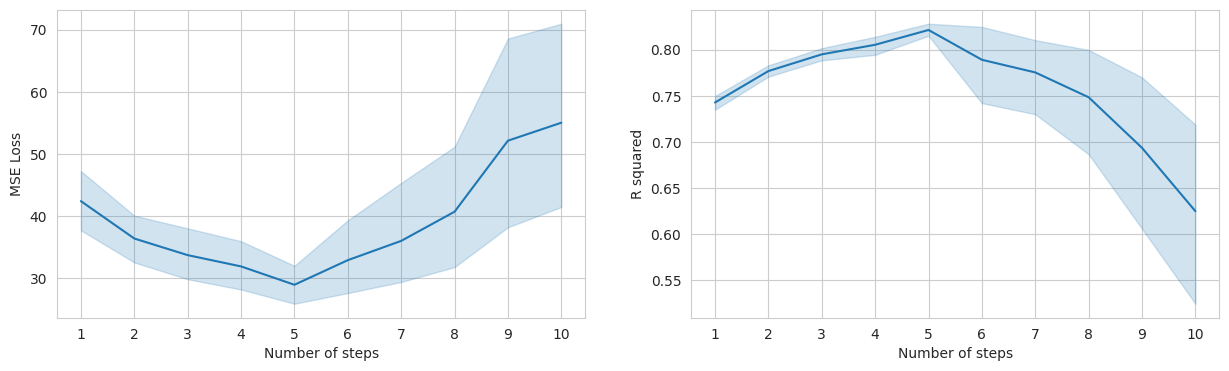

In [204]:
plot_conf_int(ilp_balancing_layers, 'ilp_balancing_layers.png')

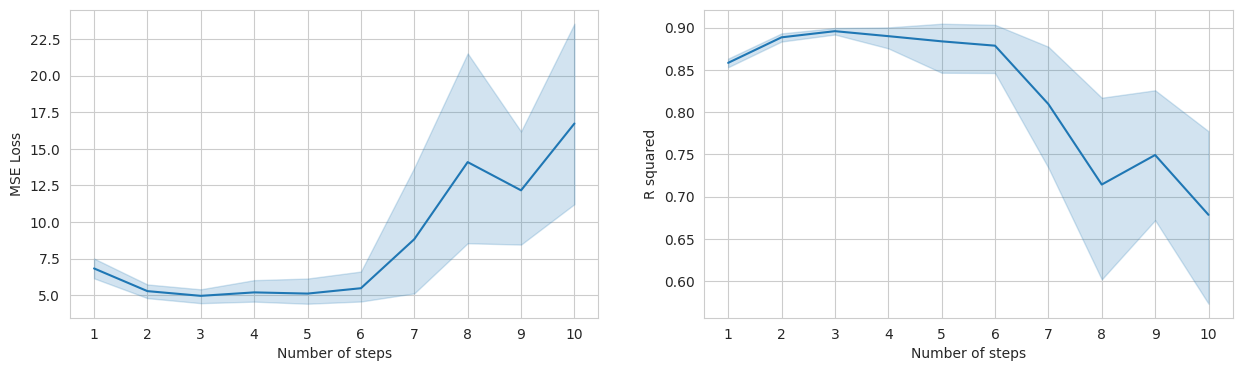

In [205]:
plot_conf_int(dcgm_balancing_layers, 'dcgm_balancing_layers.png')

In [208]:
gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

fnn_param_v1 = {"input_dim": 128 * 2 + 5, "hidden_dim": 64, "output_dim": 1, "num_layers": 4, "dropout": 0.20}
fnn_param_v2 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 4, "dropout": 0.20}

dc_gnn_model = {
    'DC-GNN_4': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2]}
}

gnn_model = {'U-GNN': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v1, fnn_param_v1]}}

In [313]:
ilp_dc_gnn_y = perform_experiments(dc_gnn_model, dataset_ilp, iter=1, shuffle=False, metric_output_file='model_output/ilp/ilp_dc_gnn_2.json')
ilp_gnn_y = perform_experiments(gnn_model, dataset_ilp, iter=1, shuffle=False, metric_output_file='model_output/ilp/ilp_gnn_2.json')

  0%|                                                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

Experiment 0

-------------------------DC-GNN_4-------------------------



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0. TRAIN: loss 138.1552, r2: -0.1414. VALIDATION loss: 239.0057, r2: -0.1691. Lr: 0.01000
Epoch 10. TRAIN: loss 90.5220, r2: 0.2521. VALIDATION loss: 149.8870, r2: 0.2668. Lr: 0.01000
Epoch 20. TRAIN: loss 71.2956, r2: 0.4110. VALIDATION loss: 111.2314, r2: 0.4559. Lr: 0.01000
Epoch 30. TRAIN: loss 62.6284, r2: 0.4826. VALIDATION loss: 95.8603, r2: 0.5311. Lr: 0.01000
Epoch 40. TRAIN: loss 55.2660, r2: 0.5434. VALIDATION loss: 94.9312, r2: 0.5356. Lr: 0.01000
Epoch 50. TRAIN: loss 51.2123, r2: 0.5769. VALIDATION loss: 78.8771, r2: 0.6142. Lr: 0.01000
Epoch 60. TRAIN: loss 45.1847, r2: 0.6267. VALIDATION loss: 80.1536, r2: 0.6079. Lr: 0.01000
Epoch 70. TRAIN: loss 43.4003, r2: 0.6414. VALIDATION loss: 73.8244, r2: 0.6389. Lr: 0.01000
Epoch 80. TRAIN: loss 39.5567, r2: 0.6732. VALIDATION loss: 69.6318, r2: 0.6594. Lr: 0.01000
Epoch 90. TRAIN: loss 37.0126, r2: 0.6942. VALIDATION loss: 64.0863, r2: 0.6865. Lr: 0.00900
Epoch 100. TRAIN: loss 34.9055, r2: 0.7116. VALIDATION loss: 62.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [57:03<00:00, 3423.13s/it]


{'in-sample loss': [20.7236, 32.4697, 24.6236, 24.0415, 24.151], 'in-sample R2': [0.8288, 0.8209, 0.8406, 0.8227, 0.8357], 'out-of-sample loss': [46.4285, 22.5877, 16.8962, 41.0054, 20.8041], 'out-of-sample R2': [0.7729, 0.7806, 0.8002, 0.8318, 0.8329]}


  0%|                                                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

Experiment 0

-------------------------U-GNN-------------------------



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0. TRAIN: loss 136.8727, r2: -0.1308. VALIDATION loss: 213.5760, r2: -0.0447. Lr: 0.01000
Epoch 10. TRAIN: loss 108.5682, r2: 0.1030. VALIDATION loss: 182.0707, r2: 0.1094. Lr: 0.01000
Epoch 20. TRAIN: loss 92.7838, r2: 0.2334. VALIDATION loss: 153.8241, r2: 0.2475. Lr: 0.01000
Epoch 30. TRAIN: loss 81.5428, r2: 0.3263. VALIDATION loss: 141.0892, r2: 0.3098. Lr: 0.01000
Epoch 40. TRAIN: loss 73.9981, r2: 0.3886. VALIDATION loss: 126.2996, r2: 0.3822. Lr: 0.01000
Epoch 50. TRAIN: loss 65.9194, r2: 0.4554. VALIDATION loss: 113.7272, r2: 0.4437. Lr: 0.01000
Epoch 60. TRAIN: loss 61.0898, r2: 0.4953. VALIDATION loss: 107.2070, r2: 0.4756. Lr: 0.01000
Epoch 70. TRAIN: loss 57.5583, r2: 0.5245. VALIDATION loss: 103.3823, r2: 0.4943. Lr: 0.01000
Epoch 80. TRAIN: loss 56.2184, r2: 0.5355. VALIDATION loss: 99.4164, r2: 0.5137. Lr: 0.01000
Epoch 90. TRAIN: loss 53.8201, r2: 0.5554. VALIDATION loss: 95.4974, r2: 0.5329. Lr: 0.01000
Epoch 100. TRAIN: loss 53.3165, r2: 0.5595. VALIDATION loss

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [50:39<00:00, 3039.97s/it]

{'in-sample loss': [34.6952, 58.7528, 48.0883, 44.6483, 48.9543], 'in-sample R2': [0.7134, 0.6759, 0.6887, 0.6708, 0.667], 'out-of-sample loss': [73.5164, 35.3173, 31.1141, 79.2197, 44.6996], 'out-of-sample R2': [0.6404, 0.657, 0.632, 0.6751, 0.641]}


In [ ]:
dcgm_dc_gnn_y = perform_experiments(dc_gnn_model, dataset_dcgm, iter=1, shuffle=False, metric_output_file='model_output/dcgm/dcgm_dc_gnn_2.json')
dcgm_gnn_y = perform_experiments(gnn_model, dataset_dcgm, iter=1, shuffle=False, metric_output_file='model_output/dcgm/dcgm_gnn_2.json')

In [314]:
from sklearn.metrics import r2_score

def get_provision_plots(y_hat_baseline, y_hat_new, dataset_, fig_name):
    y_hat_new = torch.round(torch.concat(y_hat_new))
    y_hat_baseline = torch.round(torch.concat(y_hat_baseline))
    dataset_loader = next(iter(DataLoader(dataset_, batch_size=len(dataset_))))

    x_s = dataset_loader.x_s
    x_t = dataset_loader.x_t
    edge_index = dataset_loader.edge_index
    y = dataset_loader.y

    y_sum_i = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
    y_sum_j = torch.zeros_like(x_t[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)

    y_sum_i_hat_baseline = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y_hat_baseline)
    y_sum_j_hat_baseline = torch.zeros_like(x_t[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y_hat_baseline)

    y_sum_i_hat_new = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y_hat_new)
    y_sum_j_hat_new = torch.zeros_like(x_t[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y_hat_new)

    r2_baseline = round(r2_score(y_sum_i, y_sum_i_hat_baseline),3)
    r2_new = round(r2_score(y_sum_i, y_sum_i_hat_new),3)

    fig = plt.figure(figsize=(16, 9))
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.3)
    gs = fig.add_gridspec(2,3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    ax1.hist(y_sum_i - y_sum_i_hat_baseline, bins=50, color='silver', alpha=0.7, edgecolor='none', stacked=True, label='UN-GNN')
    ax1.hist(y_sum_i - y_sum_i_hat_new, bins=50, edgecolor='none', stacked=True, alpha=0.6, label='DC-GNN')

    ax2.hist(y_sum_j - y_sum_j_hat_baseline, bins=50, color='silver', alpha=0.7, edgecolor='none', stacked=True, label='UN-GNN')
    ax2.hist(y_sum_j - y_sum_j_hat_new, bins=50, edgecolor='none', stacked=True, alpha=0.6, label='DC-GNN')

    ax3.scatter(y_sum_i, y_sum_i_hat_baseline, s=10, alpha=0.6, c="silver", label=f'UN-GNN R2 = {r2_baseline}', marker='x')
    ax3.scatter(y_sum_i, y_sum_i_hat_new, s=1, alpha=0.6, label=f'DC-GNN R2 = {r2_new}')
    ax3.plot([0, max(y_sum_i)], [0, max(y_sum_i)], linewidth=0.7, c="black")

    ax1.set_title("The distribution of out-going flows’ cumulative error", pad=20)
    ax1.set_xlabel("Absolute error in cumulative out-going flows")
    ax1.set_ylabel("Number of buildings")
    ax1.legend(loc='upper left')

    ax2.set_title("The distribution of in-going flows’ cumulative error", pad=20)
    ax2.set_xlabel("Absolute error in cumulative in-going flows")
    ax2.set_ylabel("Number of buildings")
    ax2.legend(loc='upper left')

    ax3.set_title("Provision assessment (predicted vs actual)", pad=20)
    ax3.set_xlabel("Provided population (actual)")
    ax3.set_ylabel("Provided population (predicted)")
    ax3.legend()
    
    plt.savefig(fig_name, dpi=300)
    plt.show()

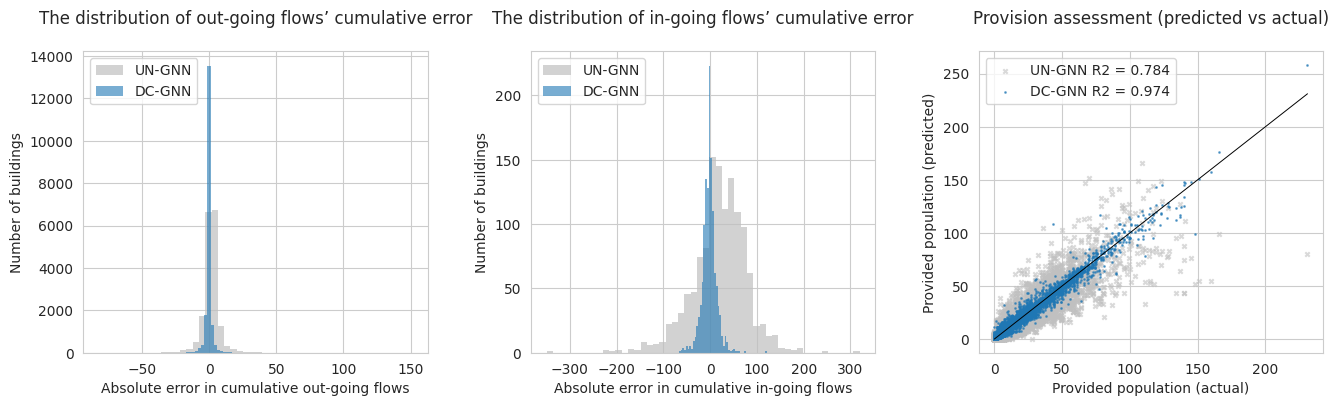

In [317]:
get_provision_plots(dcgm_gnn_y, dcgm_dc_gnn_y, dataset_dcgm, fig_name="dataset_dcgm_error_hist.png")

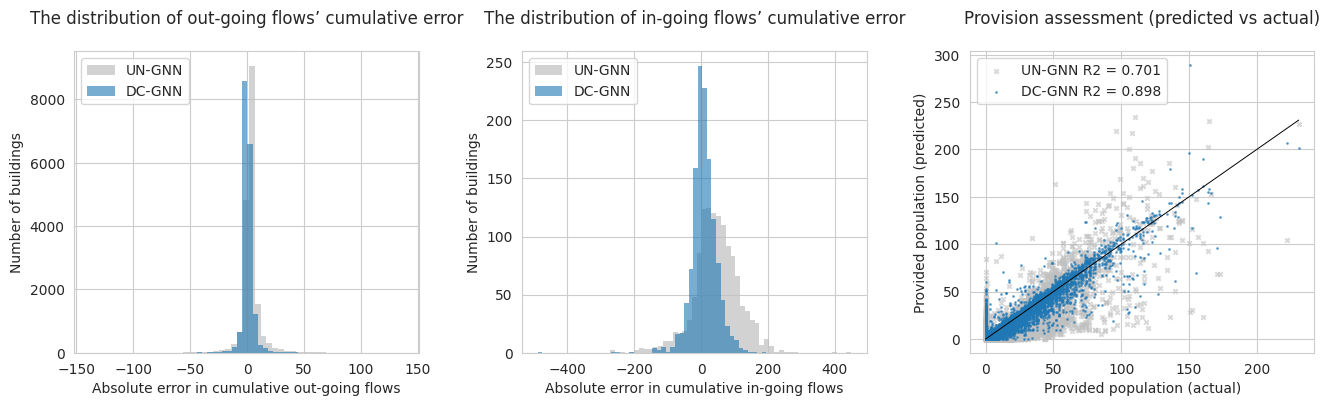

In [318]:
get_provision_plots(ilp_gnn_y, ilp_dc_gnn_y, dataset_ilp, fig_name="dataset_ilp_error_hist.png")